In [2]:
import warnings
warnings.filterwarnings('ignore')

expression
quantification
concatenaion
expression
quantification
concatenaion
expression
compa1


<ipython-input-1-b2d002712a92>:468: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


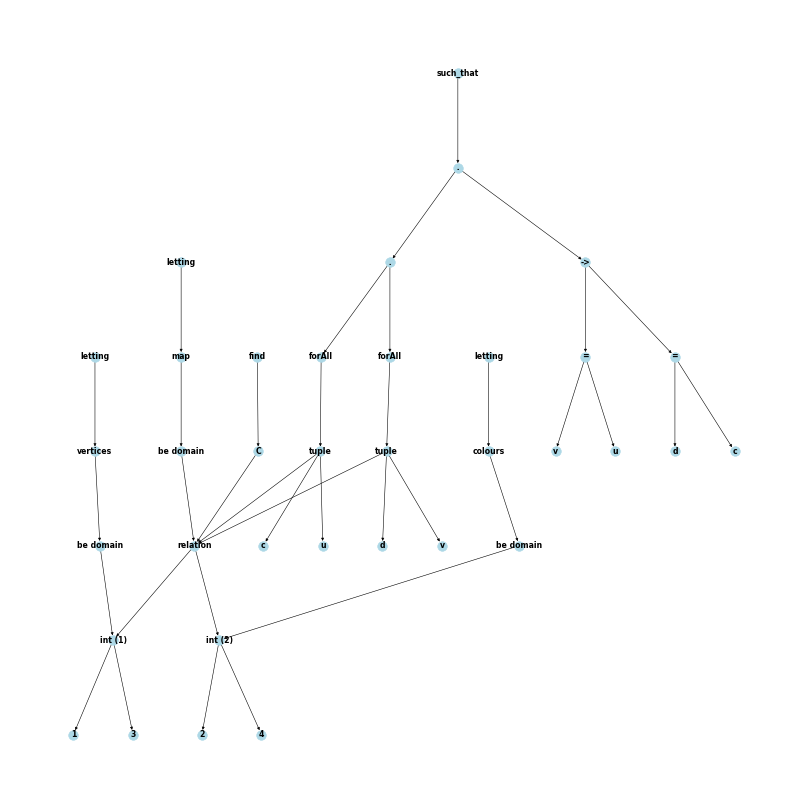

In [1]:
import re
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

class Node:
    def __init__(self, name):
        self.name = name

class Expression(Node):
    def __init__(self, value):
        super().__init__(value)
        self.value = value

class NameLettingStatement(Node):
    def __init__(self, letting, name, expression):
        super().__init__(letting)
        self.name_node = Node(name)
        self.expression = expression

class DomainNameLettingStatement(Node):
    def __init__(self, letting, name_of_domain, domain):
        super().__init__(letting)
        self.name_of_domain = Node(name_of_domain)
        self.domain = domain

class FindStatement(Node):
    def __init__(self, find, name, domain):
        super().__init__(find)
        self.name_node = Node(name)
        self.domain = domain

class SuchThatStatement(Node):
    def __init__(self, such_that, expression):
        super().__init__("such_that")
        self.expression = expression

class IntDomain(Node):
    def __init__(self, name, lower, upper):
        super().__init__(name)
        self.lower = lower
        self.upper = upper

class TupleDomain(Node):
    def __init__(self, name, domains):
        super().__init__(name)
        self.domains = domains

class RelationDomain(Node):
    def __init__(self, name, domains):
        super().__init__(name)
        self.domains = domains

class NameDomain(Node):
    def __init__(self, name):
        super().__init__(name)

class Operator(Node):
    def __init__(self, name):
        super().__init__(name)
        
class BinaryExpression(Node):
    def __init__(self, left, operator, right):
        super().__init__(operator.name)
        self.left = left
        self.operator = operator
        self.right = right

class TupleConstant(Expression):
    def __init__(self, values):
        super().__init__(values)
        self.name = "tuple"
        self.values = values

class TupleVariable(Node):
    def __init__(self, elements):
        super().__init__('tuple')
        self.elements = elements

class RelationConstant(Expression):
    def __init__(self, values):
        super().__init__(values)
        self.name = "relation"
        self.values = values

class QuantificationExpression(Node):
    def __init__(self, quantifier, variables, domain):
        super().__init__(quantifier)
        self.variables = variables
        self.domain = domain
        #self.expression = expression

class ConcatenationExpression(Node):
    def __init__(self, left, right):
        super().__init__(" . ")
        self.left = left
        self.right = right

     

class EssenceParser:
    def __init__(self, input_str):
        self.tokens = re.findall(r'\.\.|\->|\\\/|\/\\|>=|<=|!=|[^\s\w]|[\w]+', input_str.replace('\n', ' '))
        self.index = 0
        self.named_domains = {} 
        self.binary_operators = ["<",">", "<=", ">=", "+", "-", "*", "/", "%", "="]

    def parse(self):
      statements = []
      while self.index < len(self.tokens):
          statement = self.parse_statement()
          if isinstance(statement, DomainNameLettingStatement):
              self.named_domains[statement.name_of_domain.name] = statement.domain
          if isinstance(statement, FindStatement):
              self.named_domains[statement.name_node.name] = statement.domain
          statements.append(statement)
      return statements

    def consume(self):
        token = self.tokens[self.index]
        self.index += 1
        return token

    def match(self, expected):
        return self.index < len(self.tokens) and self.tokens[self.index] == expected

    def parse_statement(self):
        if self.match("letting"):          
          if self.tokens[self.index + 2] == "be" and self.tokens[self.index + 3] == "domain":
            return self.parse_domain_name_letting_statement()
          if self.tokens[self.index + 2] == "be":
            return self.parse_name_letting_statement()
          else:
              raise SyntaxError("Invalid letting statement: " + str(self.tokens[self.index]))
        elif self.match("find"):
            return self.parse_find_statement()
        elif self.match("such"):
            return self.parse_such_that_statement()
        else:
            raise SyntaxError("Invalid statement:" +str( self.tokens[self.index]) + " Token Num: " + str(self.index))

    def parse_name_letting_statement(self):
        letting = self.consume()  # "letting"
        name = self.consume()  # Name
        self.consume()  # "be"
        expression = self.parse_expression()
        return NameLettingStatement(letting, name, expression)

    def parse_domain_name_letting_statement(self):
        letting = self.consume()  # "letting"
        name_of_domain = self.consume()  # NameDomain
        self.consume()  # "be "
        self.consume()  # "domain"
        domain = self.parse_domain()
        return DomainNameLettingStatement(letting, name_of_domain, domain)

    def parse_find_statement(self):
        find = self.consume()  # "find"
        name = self.consume()  # Name
        colon = self.consume()  # ":"
        domain = self.parse_domain()        
        return FindStatement(find, name, domain)

    def parse_such_that_statement(self):
        such_that = self.consume()  # "such"
        self.consume()  # "that"
        expression = self.parse_expression()
        while self.match("."):
          print("concatenaion")
          self.consume()  # "."
          next_expression = self.parse_expression()
          expression = ConcatenationExpression(expression, next_expression)
        return SuchThatStatement(such_that, expression)

    def parse_domain(self):
        if self.match("int"):
            domain_name = self.consume()  # "int"
            self.consume()  # "("
            lower = self.consume()  # Lower bound
            self.consume()  # ".."
            upper = self.consume()  # Upper bound
            self.consume()  # ")"
            return IntDomain(domain_name, lower, upper)
        elif self.match("tuple"):
            domain_name = self.consume()  # "tuple"
            self.consume()  # "("
            domains = []
            while not self.match(")"):
                domains.append(self.parse_domain())
                if self.match(","):
                    self.consume()  # ","
            self.consume()  # ")"
            return TupleDomain(domain_name, domains)

        elif self.match("relation"):
            domain_name = self.consume()  # "relation"
            self.consume()  # "of"
            self.consume()  # "("
            domains = []
            while not self.match(")"):
                domains.append(self.parse_domain())
                if self.match("*"):
                    self.consume()  # "*"
            self.consume()  # ")"
            return RelationDomain(domain_name, domains)
        elif self.tokens[self.index] in self.named_domains:
          name_of_domain = self.consume()
          return self.named_domains[name_of_domain]
        else:
            raise SyntaxError("Domain Parsing Error. Token: " + str(self.tokens[self.index]))
    
    def parse_term(self):
        return Expression(self.consume())  # Literal (integerConstant)

    def parse_operator(self):
        return Operator(self.consume())

    def match_any(self, tokens):
        return any(self.match(token) for token in tokens)

    def parse_expression(self):
        print("expression")
        
        left = None
        if self.match("(") and self.tokens[self.index + 2] != ",":
            print("compa1")
            self.consume()  # "("
            left = self.parse_comparison()
            self.consume()  # ")"
        elif self.match("(") and self.tokens[self.index + 2] == ",":
            print("tuple constant")
            left = self.parse_tuple_constant()
        elif self.match("relation"):  
            print("relation constant")
            left = self.parse_relation_constant()
        elif self.match_any(["forAll", "exists"]):
            print("quantification")
            left = self.parse_quantification()
        else:
            print("comparison")
            left = self.parse_comparison()
        
        while self.match_any(self.binary_operators):
            operator = Operator(self.consume())
            right = self.parse_comparison()
            left = BinaryExpression(left, operator, right)

        return left


        
    def parse_parenthesized_expression(self):
        self.consume()  # "("
        expression = self.parse_comparison()
        self.consume()  # ")"
        return expression

    def parse_comparison(self):
        left = self.parse_addition()

        while self.match_any(["<", ">", "<=", ">=", "=", "->"]):
            operator = Operator(self.consume())
            right = self.parse_addition()
            left = BinaryExpression(left, operator, right)

        return left

    def parse_addition(self):
        left = self.parse_multiplication()

        while self.match_any(["+", "-"]):
            operator = Operator(self.consume())
            right = self.parse_multiplication()
            left = BinaryExpression(left, operator, right)

        return left

    def parse_multiplication(self):
        if self.match("("):
            left = self.parse_parenthesized_expression()
        else:
            left = self.parse_term()

        while self.match_any(["*", "/", "%"]):
            operator = Operator(self.consume())
            if self.match("("):
                right = self.parse_parenthesized_expression()
            else:
                right = self.parse_term()
            left = BinaryExpression(left, operator, right)

        return left
    
    def parse_tuple_constant(self):
        self.consume()  # "("
        values = []
        while not self.match(")"):
            values.append(Expression(self.consume()))  # Literal (integerConstant)
            if self.match(","):
                self.consume()  # ","
        self.consume()  # ")"
        return TupleConstant(values)

    def parse_relation_constant(self):
        self.consume()  # "relation"
        self.consume()  # "("
        values = []
        while not self.match(")"):
            if self.match("("):
                values.append(self.parse_tuple_constant())
            if self.match(","):
                self.consume()  # ","
        self.consume()  # ")"
        return RelationConstant(values)

    def parse_quantification(self):
        quantifier = self.consume()  # "forAll" or "exists"
        variables = []

        while not self.match_any([":", "in"]):
            if self.match("("):
                self.consume()  # "("
                tuple_elements = []
                while not self.match(")"):
                    tuple_elements.append(Node(self.consume()))
                    if self.match(","):
                        self.consume()  # ","
                self.consume()  # ")"
                variables = TupleVariable(tuple_elements)
            else:
                variables.append(Node(self.consume()))
                if self.match(","):
                    self.consume()  # ","

        self.consume()  # ":"
        domain = self.parse_domain()

        return QuantificationExpression(quantifier, variables, domain)



def add_tree_node(graph, node, parent=None, index=None):
      unique_id = id(node)

      if index is not None:
          label = f"{node.name} ({index})"
      else:
          label = node.name
          

      graph.add_node(unique_id, label=label)

      if parent:
          graph.add_edge(id(parent), unique_id)


def add_nodes_edges(graph, node, parent=None, index=None):
    unique_id = id(node)

    if index is not None:
        label = f"{node.name} ({index})"
    else:
        label = node.name
        

    graph.add_node(unique_id, label=label)

    if parent:
        graph.add_edge(id(parent), unique_id)

    if isinstance(node, (NameLettingStatement, FindStatement)):
        add_nodes_edges(graph, node.name_node, parent=node)

    if isinstance(node, NameLettingStatement):
        if isinstance(node.expression, RelationConstant): 
            add_nodes_edges(graph, node.expression, parent=node.name_node)
        else:
            add_nodes_edges(graph, node.expression, parent=node.name_node)
    
    if isinstance(node, DomainNameLettingStatement):
        add_nodes_edges(graph, node.name_of_domain, parent=node)
        be_domain_node = len(list(graph.nodes()))
        graph.add_node(id(be_domain_node), label="be domain")
        graph.add_edge(id(node.name_of_domain),id(be_domain_node))
        add_nodes_edges(graph, node.domain, parent=be_domain_node)


    if isinstance(node, FindStatement):
        add_nodes_edges(graph, node.domain, parent=node.name_node)

    if isinstance(node, SuchThatStatement):
        add_nodes_edges(graph, node.expression, parent=node)

    if isinstance(node, IntDomain):
        lower_unique_id = id(node.lower)
        upper_unique_id = id(node.upper)
        graph.add_node(lower_unique_id, label=node.lower)
        graph.add_node(upper_unique_id, label=node.upper)
        graph.add_edge(unique_id, lower_unique_id)
        graph.add_edge(unique_id, upper_unique_id)
    
    if isinstance(node, BinaryExpression):
        #operator_node = Node(node.operator)
        #graph.add_node(operator_node.name, label=str(node.operator.name))
        #add_nodes_edges(graph, node.operator, parent=node)
        add_nodes_edges(graph, node.left, parent=node)
        add_nodes_edges(graph, node.right, parent=node)

    if isinstance(node, TupleDomain):
        for index, domain in enumerate(node.domains, start=1):
            index_node = Node(f"{node.name}_{index}")
            graph.add_node(index_node.name, label=str(index))
            graph.add_edge(node.name, index_node.name)
            add_nodes_edges(graph, domain, parent=index_node)

    if isinstance(node, RelationDomain):
        for i, domain in enumerate(node.domains, start=1):
            add_nodes_edges(graph, domain, parent=node, index=i)

    if isinstance(node, TupleConstant):
        for i, value in enumerate(node.values, start=1):
            add_nodes_edges(graph, value, parent=node, index=i)

    if isinstance(node, RelationConstant):
        for i, value in enumerate(node.values, start=1):
            add_nodes_edges(graph, value, parent=node, index=i)

    if isinstance(node, QuantificationExpression):
        # Add quantifier node
        #graph.add_node(node.name)

        # Add variables and edges to the graph
        if  isinstance(node.variables,  TupleVariable):
            add_nodes_edges(graph, node.variables, parent=node)
            add_nodes_edges(graph, node.domain, parent=node.variables)
        else:
            for variable in node.variables:
                #print(variable)
                add_nodes_edges(graph, Node(variable.name), parent=node)
                add_nodes_edges(graph, node.domain, parent=Node(variable.name))

        # Add domain node and edges to the graph
        #add_nodes_edges(graph, node.domain, parent=node)
    if isinstance(node, TupleVariable):
        # Add tuple elements and edges to the graph
        for element in node.elements:
            #print("lskdflf")
            #print(element.name)
            add_nodes_edges(graph, element, parent=node)
            #graph.add_edge(node.name, element.name)

    if isinstance(node, ConcatenationExpression):
        add_nodes_edges(graph, node.left, parent=node)
        add_nodes_edges(graph, node.right, parent=node)

        
def createASG(ast):
    G = nx.DiGraph()

    for item in ast:
        add_nodes_edges(G, item)
    
    return G

def createNXAST(ast):
    G = nx.DiGraph()

    for ast in asts:
        add_nodes_edges(G, ast)
    
    return G

input_str = """letting vertices be domain int(1..3)
letting colours be domain int(2..4)
letting map be domain relation of (vertices * colours)
find C : map
such that
  forAll (u,c) in C .
     forAll (v,d) in C .
        ((u = v) -> (c = d))"""
parser = EssenceParser(input_str)
asts = parser.parse()

G = nx.DiGraph()

for ast in asts:
    add_nodes_edges(G, ast)


labels = nx.get_node_attributes(G, 'label')
plt.figure(figsize=(20,20),dpi=40) 
pos = graphviz_layout(G, prog="dot")
#pos = nx.spring_layout(G,k= 3,iterations=450)
nx.draw(G,pos,with_labels=True,labels=labels, node_size=300, node_color="lightblue", font_size=14, font_weight="bold")
plt.show()


In [3]:
def parseAndPlot(input_str):
  parser = EssenceParser(input_str)
  asts = parser.parse()

  G = nx.DiGraph()

  for ast in asts:
      add_nodes_edges(G, ast)

  labels = nx.get_node_attributes(G, 'label')
  pos = graphviz_layout(G, prog="dot")
  plt.figure(figsize=(10,10)) 
  nx.draw(G,pos,with_labels=True,labels=labels, node_size=400, node_color="lightblue", font_size=12, font_weight="bold")
  plt.show()

expression
compa1


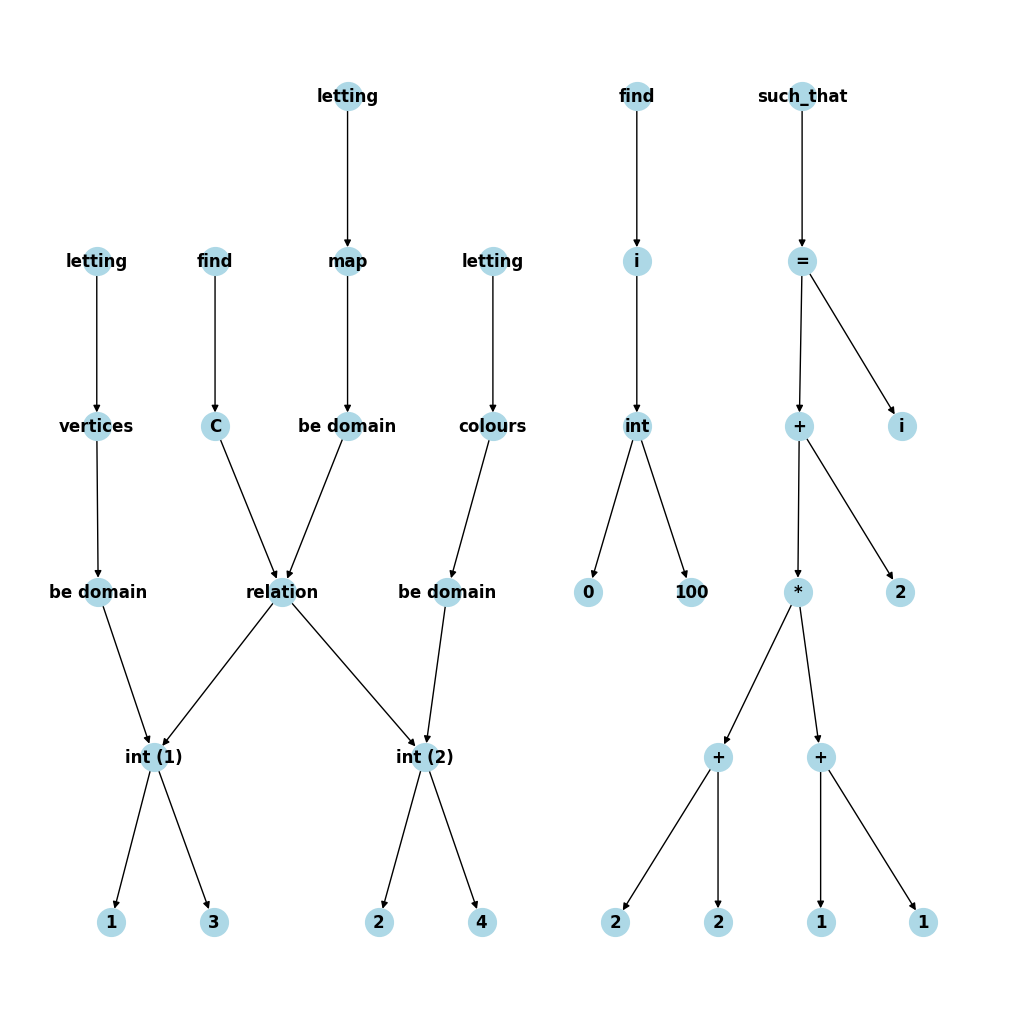

In [7]:
input = """ letting vertices be domain int(1..3)
letting colours be domain int(2..4)
letting map be domain relation of (vertices * colours)
find C : map
find i: int(0..100)
such that
  (((2+2)*(1+1))+2)=i
"""
parseAndPlot(input)